In [2]:
import gsc
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns

net = gsc.load_model('../training/s50Gram_nSim70_vSim00.pkl')  ## load up a trained model

In [3]:
# same settings as used in main sims
input_decay_rate = 0.90
duration = 15
num_terminal_roles = net.hg.opts['max_sent_len']

def extract_terminals(gp, use_type=True):
    
    terminals = [bname.split('/')[0] for bname in gp[:net.hg.opts['max_sent_len']]]
    if use_type:
        terminals = [fname.split(':')[0] for fname in terminals]
        
    return terminals

In [4]:
## setup Ns Np Preamble 
input_terminals = ['Ns:0/(1,1)','Np:1/(1,2)']
partial_input_terminals = ['Ns:1/(1,1)','Np:0/(1,2)']
input_phrases = ['NPCs[2]:0/(2,1)']
input_sentence = ['S[3]:0/(3,1)']

## Responses of interest
## : Nonterminals were ignored; only terminals are observable from participants' responses
#resp_type1 = [
#    ['Ns', 'Np', 'Vs', '@'],   # correct
#    ['Ns', 'Np', 'Vp', '@'],   # attraction error
#    ['Ns', 'Ns', 'Vs', '@'],   # preamble error: local change
#    ['Np', 'Np', 'Vp', '@'],   # preamble error: head change
#]

#resfilename1  = 's50Gram_NsNp_nSim70_vSim00_result.pkl'
#plotfilename1 = 's50Gram_NsNp_nSim70_vSim00_result.png'


['(1,1)', '(1,2)', '(1,3)', '(1,4)', '(2,1)', '(2,2)', '(2,3)', '(3,1)', '(3,2)', '(4,1)']
['#:0', '*@:1', '*Np:0', '*Ns:0', '*Vp:1', '*Vs:1', '@:1', 'NPCp[1]:0', 'NPCp[2]:0', 'NPCp[3]:0', 'NPCp[4]:0', 'NPCs[1]:0', 'NPCs[2]:0', 'NPCs[3]:0', 'Np:0', 'Np:1', 'Ns:0', 'Ns:1', 'RC[1]:1', 'RC[2]:1', 'S[1]:0', 'S[2]:0', 'S[3]:0', 'S[4]:0', 'Vp:1', 'Vs:1', '_']


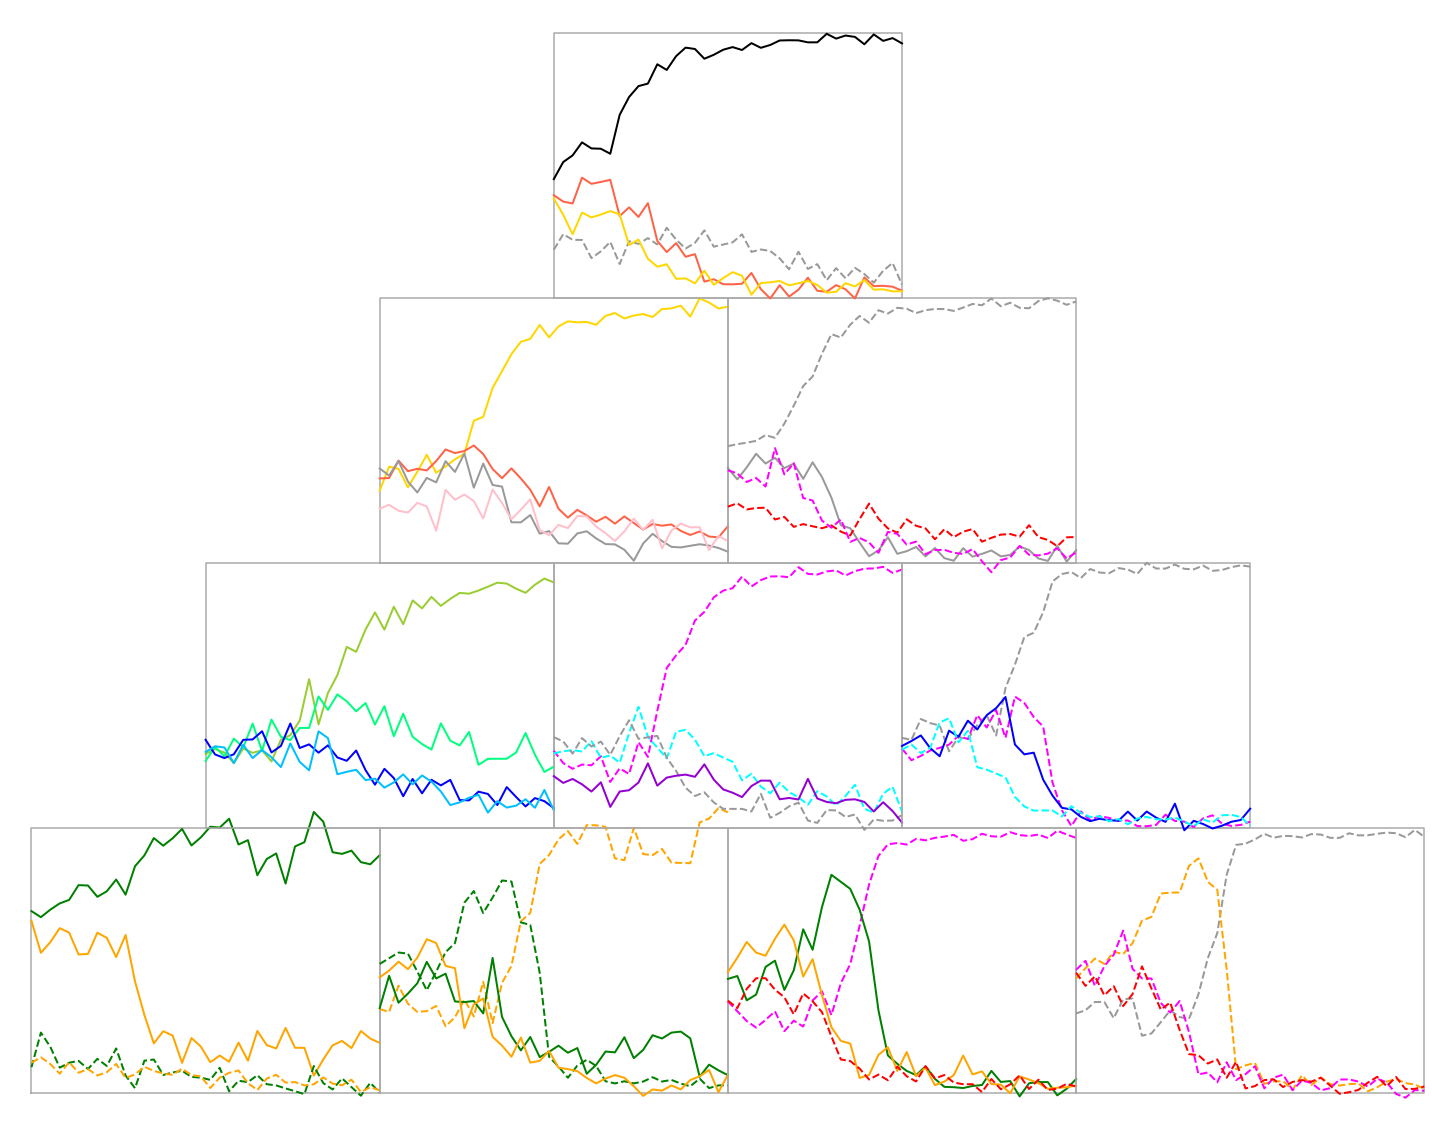

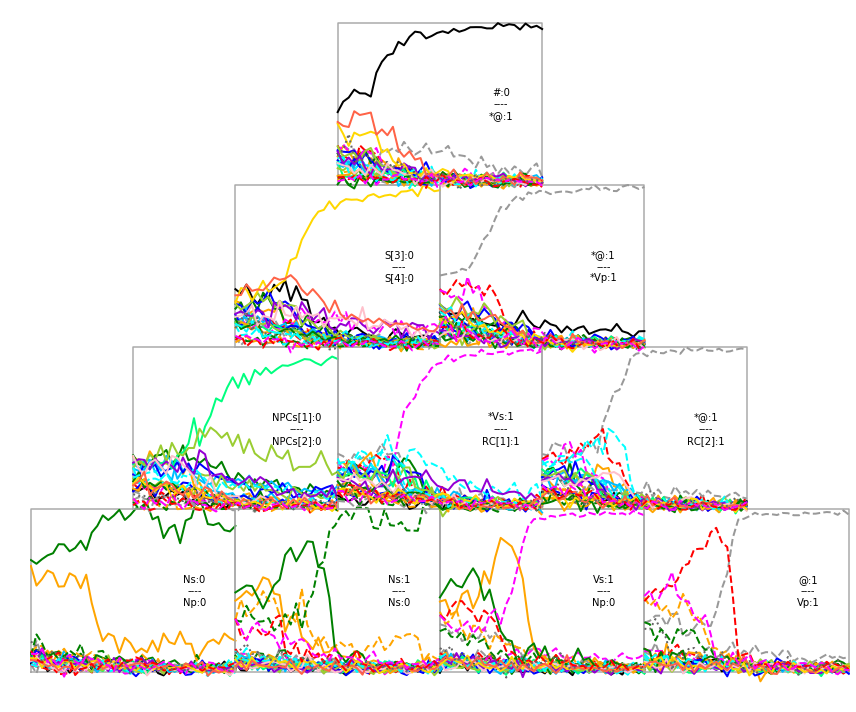

In [5]:
### run the Ns Np preamble input
np.random.seed(9)   #some seed values: 1 = correct, 4 verb error, 9 preamble error 

# pure 'unambiguous' external input to target non-terminal bindings in role (2,1) and (3,1)
extC_nonterminals = np.zeros(net.num_bindings)
extC_nonterminals[net.find_bindings(input_sentence + input_phrases)] = 1.

# pure 'ambiguous' external input to input-consistent terminal bindings in role (1,1) and (1,2)
# Note that I used 'input_terminals + partial_input_terimansl' 
extC_terminals = np.zeros(net.num_bindings)
extC_terminals[net.find_bindings(input_terminals + partial_input_terminals)] = 1.

## set encoding weight
w=.5  # we want 50% terminal, and 50% non-terminal input
curr_extC = (1-w) * extC_terminals + w * extC_nonterminals

## run one trial
net.reset(mu=net.ep, sd=0.02)
net.extC += 1. * curr_extC # set conceptual level input
net.ext = net.C2N(net.extC) # rotate to neural coordinates

for i in range(duration):
    net.run(1, plot=True, log_trace=True)
    net.extC = net.extC * input_decay_rate
    net.ext = net.C2N(net.extC)
    
    
net.plot_tree_actC_trace(savefilename='traceNsNp_simpler.png',print_winner=False, linewidth=2,downsampling=80, figsize=(20,16),top_k=4,
                         colors=['#008000', '#FFA500', '#008000', '#FFA500',
                                 '#FFA500', '#008000', '#008000', '#FFA500',
                                 '#FF00FF', '#008000', '#FFA500', '#FF0000', 
                                 '#999999', '#FFA500', '#FF00FF', '#FF0000', 
                                 '#9ACD32', '#00FF7F', '#0000FF', '#00BFFF', 
                                 '#FF00FF', '#00FFFF', '#999999', '#9400D3',
                                 '#999999', '#FF00FF', '#0000FF', '#00FFFF',
                                 '#FFD700', '#FF6347', '#999999', '#FFC0CB', 
                                 '#999999', '#999999', '#FF0000', '#FF00FF', 
                                 '#000000', '#999999', '#FF6347', '#FFD700'],
                        lty=['-', '-', '--', '--',
                             '--', '--', '-', '-',
                             '--', '-', '-', '--', 
                             '--', '--', '--', '--', 
                             '-', '-', '-', '-',
                             '--', '--', '--', '-', 
                             '--', '--', '-', '--', 
                             '-', '-', '-', '-', 
                             '--', '-', '--', '--',
                             '-', '--', '-', '-'])


    
net.plot_tree_actC_trace(savefilename='traceNsNp.png', linewidth=2,downsampling=80, figsize=(12,10),
                         lty=['-', '--', '-', '-', '--', '--', '--', '-', '-', '-', '-', '-', '-', '-', '-', '--', '-', '--', '--', '--', '-', '-', '-', '-', '--', '--', ':'],
                         colors=['#000000', '#999999', '#FFA500', '#008000', '#FF0000', '#FF00FF', '#999999', '#00BFFF', '#00BFFF', '#0000FF', '#0000FF', '#00FF7F', '#9ACD32', '#9ACD32', '#FFA500', '#FFA500', '#008000', '#008000', '#00FFFF', '#00FFFF', '#9400D3', '#FFC0CB', '#FFD700', '#FF6347', '#FF0000', '#FF00FF', '#666666'])


print(net.role_names)
print(net.filler_names)

In [6]:
### the fillers....
#	#000000
#S[1]	#9400D3
#S[2]	#FFC0CB
#S[3]	#FFD700
#S[4]	#FF6347

#NPCs[1]	#00FF7F
#NPCs[2]	#9ACD32

#NPCp[2]	#00BFFF
#NPCp[3]	#0000FF

#RC[1]	#00FFFF

#Np	#FFA500
#Ns	#008000

#Vp	#FF0000
#Vs	#FF00FF

#@	#999999

## left and right child
#0	-
#1	--
